In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
np.random.seed(0)

In [122]:
class neural_network():

    def __init__ (self, network_structure):
        self.network_structure = network_structure

        self.build_network(self.network_structure)
        if (self.network_structure[-1] == 1):
            self.classification = 'binary'
        else:
            self.classification = 'multi'

        self.M_W = 0
        self.M_b = 0
        self.S_W = 0
        self.S_b = 0

        self.exist_validation = False

        self.best_loss = 100
        self.best_acc = 0
        self.best_loss_val = 100
        self.best_acc_val = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def div_sigmoid(self, z):
        sig_z = self.sigmoid(z)
        return(np.multiply(sig_z,(1 - sig_z)))

    def softmax(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def build_network (self, neurons_number):
        Weight = []
        bias = []
        for i in range(len(neurons_number) - 1):
            Weight.append(np.random.randn(neurons_number[i], neurons_number[i+1]))
            bias.append(np.zeros(neurons_number[i+1]))

        self.W = np.array(Weight , dtype='object')
        self.b = np.array(bias , dtype='object')

    def forward_propagation(self, X):
        a = np.copy(X)
        Z = []
        A = []
        for indx, w in enumerate(self.W):
            if (indx == len(self.W)-1):
                if (self.classification == 'binary'):
                    z = np.dot(a, w) + self.b[indx]
                    Z.append(z)
                    a = self.sigmoid(z)
                    A.append(a)
                elif (self.classification == 'multi'):
                    z = np.dot(a, w) + self.b[indx]
                    Z.append(z)
                    a = self.softmax(z)
                    A.append(a)
            else:
                z = np.dot(a, w) + self.b[indx]
                Z.append(z)
                a = self.sigmoid(z)
                A.append(a)
        return(Z, A)

    def backward_propagation(self, Z, label):
        delta = []
        for indx in range(len(Z)):
            if (indx == 0):
                if (self.classification == 'binary'):
                    delta.append(2 * (self.sigmoid(Z[-1]) - label) * self.div_sigmoid(Z[-1]))
                elif (self.classification == 'multi'):
                    delta.append((self.softmax(Z[-1]) - label))
            else:
                # delta.append( np.multiply( ( np.dot(self.W[len(Z) - indx], delta[indx-1].T) ).T , ( self.div_sigmoid( Z[len(Z) - (indx+1)] ) ) ) )
                delta.append( ( np.dot( delta[indx-1],    self.W[len(Z) - indx].T)) * ( self.div_sigmoid( Z[len(Z) - (indx+1)] ) ) )
        return(delta)

    def gradient(self, delta, X, A):
        gradient_weights_list = []
        gradient_biases_list = []
        for i in range(len(delta)):
            if (i == 0):
                gradient_weights_list.append(np.dot(X.T, delta[-1]))
                gradient_biases_list.append(np.sum(delta[-1], axis=0))
            else:
                gradient_weights_list.append(np.dot(A[i-1].T, delta[-(i+1)]))
                gradient_biases_list.append(np.sum(delta[-(i+1)], axis=0))

        gradient_weights_list = np.array(gradient_weights_list , dtype='object')
        gradient_biases_list = np.array(gradient_biases_list , dtype='object')
        return(gradient_weights_list, gradient_biases_list)

    def update_weights(self, gradient_weights, gradient_biases, lr):
        self.W -= (gradient_weights * lr)
        self.b -= (gradient_biases * lr)

    def mini_batch (self, X, y, batch_size):
        m = X.shape[0]
        num_batches = m // batch_size
        if m % batch_size != 0:
            num_batches += 1

        shuffled_indices = np.random.permutation(m)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, m)
            batch_X = X_shuffled[start_idx:end_idx]
            batch_y = y_shuffled[start_idx:end_idx]
            yield (batch_X, batch_y, False)
        yield (None, None, True)

    def adam(self, gradient_weights, gradient_biases, beta_1, beta_2, k, epsilon = 0.001):

        self.M_W = beta_1 * self.M_W + (1 - beta_1) * gradient_weights
        self.M_b = beta_1 * self.M_b + (1 - beta_1) * gradient_biases

        self.S_W = beta_2 * self.S_W + (1 - beta_2) * (gradient_weights ** 2)
        self.S_b = beta_2 * self.S_b + (1 - beta_2) * (gradient_biases ** 2)

        M_W_bar = self.M_W / (1 - (beta_1 ** k))
        M_b_bar = self.M_b / (1 - (beta_1 ** k))

        S_W_bar = self.S_W / (1 - (beta_2 ** k))
        S_b_bar = self.S_b / (1 - (beta_2 ** k))

        new_gradient_weights = M_W_bar / ((S_W_bar ** 0.5) + epsilon)
        new_gradient_biases = M_b_bar / ((S_b_bar ** 0.5) + epsilon)

        return(new_gradient_weights, new_gradient_biases)

    def fit(self, data, label, validation_data = None,
            iteration = 1, print_info = 1, learning_rate = 0.01,
            use_mini_batch = True, batch_size_ = 32,
            use_adam = True, adam_beta_1 = .999, adam_beta_2 = .999):

        self.loss_information = []
        self.accuracy_information = []
        if (validation_data is not None):
            self.exist_validation = True
            self.val_loss_information = []
            self.val_accuracy_information = []

        # Check for using mini batch
        if (use_mini_batch):
            mini_batch_itr = self.mini_batch(data, label, batch_size = batch_size_)
        else:
            X = np.copy(data)
            y = np.copy(label)

        for itr in range(iteration):
            # get batch if we are using mini batch
            if (use_mini_batch):
                X, y, flag_epoch = next(mini_batch_itr)
                if (flag_epoch):
                    # print("one epoch has been finished in iteration: ", itr+1)
                    mini_batch_itr = self.mini_batch(data, label, batch_size = batch_size_)
                    X, y, flag_epoch = next(mini_batch_itr)

            # Store training curve information
            if (itr+1) % print_info == 0:
                predict, out_put = self.predict(data)
                loss = np.sum((out_put[-1] - label) **2) / data.shape[0]
                acc = accuracy_score(predict, np.argmax(label, axis=1))
                if (loss < self.best_loss):
                    self.best_loss = loss
                if (acc > self.best_acc):
                    self.best_acc = acc
                self.loss_information.append(loss)
                self.accuracy_information.append(acc)

                if(self.exist_validation):
                    val_predict, val_out_put = self.predict(validation_data[0])
                    loss_val = np.sum((val_out_put[-1] - validation_data[1]) **2) / validation_data[0].shape[0]
                    acc_val = accuracy_score(val_predict, np.argmax(validation_data[1], axis=1))
                    if (loss_val < self.best_loss_val):
                        self.best_loss_val = loss
                    if (acc_val > self.best_acc_val):
                        self.best_acc_val = acc
                    self.val_loss_information.append(loss_val)
                    self.val_accuracy_information.append(acc_val)

                # print accuracy and loss
                if self.exist_validation:
                    print(f"Iteration {itr+1}:\t" ,
                        "Loss = {:0.6f},\tAccuracy = {:0.2f},\t".format(self.loss_information[-1], self.accuracy_information[-1]),
                        "Validation Loss = {:0.6f},\tValidation Accuracy = {:0.2f}".format(self.val_loss_information[-1],
                                                                                            self.val_accuracy_information[-1]))
                else:
                    print(f"Iteration {itr+1}:\t" ,
                          "Loss = {:0.6f},\tAccuracy = {:0.2f},\t".format(self.loss_information[-1], self.accuracy_information[-1]))

            # Forward Propagation
            Z, A = self.forward_propagation(X)

            # Calculating deltas
            delta = self.backward_propagation (Z, y)

            # Calculating gradient
            grad_sum_W, grad_sum_b = self.gradient(delta, X, A)

            # Check for using adam
            if (use_adam):
                ada_grad_W, ada_grad_b = self.adam(grad_sum_W, grad_sum_b, adam_beta_1, adam_beta_2, itr+1)
                self.update_weights(ada_grad_W, ada_grad_b, learning_rate)
            else:
                self.update_weights(grad_sum_W, grad_sum_b, learning_rate)

    def plot_history(self):
        legends = ['Train']
        plt.plot(range(len(self.accuracy_information)), self.accuracy_information, color='red')
        if (self.exist_validation):
            legends.append('Validation')
            plt.plot(range(len(self.val_accuracy_information)), self.val_accuracy_information, color='green')
        plt.title('ACC History')
        plt.legend(legends)
        plt.grid()
        plt.show()

        plt.plot(range(len(self.loss_information)), self.loss_information, color='red')
        if (self.exist_validation):
            plt.plot(range(len(self.val_loss_information)), self.val_loss_information, color='green')
        plt.title('Loss History')
        plt.legend(legends)
        plt.grid()
        plt.show()

    def predict (slef, X):
        _, out_put = slef.forward_propagation(X)
        if (slef.classification == 'binary'):
            predict = np.where(out_put[-1] < 0.5, 0, 1)
        elif (slef.classification == 'multi'):
            predict = np.argmax(out_put[-1], axis=1)

        return(predict, out_put)



In [123]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28 * 28)) / 255.
    return images.astype('float32')

In [124]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from collections import Counter

In [125]:
# Create a multi-class dataset using scikit-learn
dataset, label = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=3, n_clusters_per_class=1,
                           random_state=0)

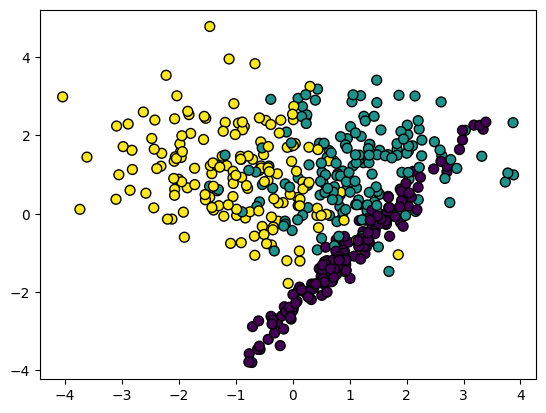

In [126]:
# Plot the dataset
plt.scatter(dataset[:, 0], dataset[:, 1], marker='o', c=label, s=50, edgecolor='k')
plt.show()

In [127]:
counter = Counter(label)
counter

Counter({0: 167, 1: 169, 2: 164})

In [128]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=42, stratify=label)

In [129]:
counter = Counter(y_train)
counter

Counter({0: 134, 2: 131, 1: 135})

In [130]:
counter = Counter(y_test)
counter

Counter({2: 33, 1: 34, 0: 33})

In [131]:
# Normalize the input data
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
flag_is_binary = False
if (flag_is_binary):
    Y_train = y_train.reshape(-1,1)
    Y_test = y_test.reshape(-1,1)
else:
    Y_train = np.zeros((y_train.size, y_train.max() + 1))
    Y_train[np.arange(y_train.size), y_train] = 1
    Y_test = np.zeros((y_test.size, y_test.max() + 1))
    Y_test[np.arange(y_test.size), y_test] = 1

In [132]:
nn = neural_network((X_train.shape[1], 20, 20, 20, Y_train.shape[1]))
print(nn.network_structure)

(2, 20, 20, 20, 3)


In [133]:
nn.fit(X_train, Y_train, (X_test, Y_test),
       iteration = 10000, print_info = 1,
       use_mini_batch = True , use_adam = True)

Iteration 1:	 Loss = 1.020965,	Accuracy = 0.28,	 Validation Loss = 1.066855,	Validation Accuracy = 0.28
Iteration 2:	 Loss = 0.915536,	Accuracy = 0.19,	 Validation Loss = 0.971962,	Validation Accuracy = 0.13
Iteration 3:	 Loss = 0.831018,	Accuracy = 0.24,	 Validation Loss = 0.880288,	Validation Accuracy = 0.14
Iteration 4:	 Loss = 0.761794,	Accuracy = 0.28,	 Validation Loss = 0.801115,	Validation Accuracy = 0.23
Iteration 5:	 Loss = 0.707657,	Accuracy = 0.32,	 Validation Loss = 0.741379,	Validation Accuracy = 0.35
Iteration 6:	 Loss = 0.663748,	Accuracy = 0.52,	 Validation Loss = 0.693661,	Validation Accuracy = 0.51
Iteration 7:	 Loss = 0.628010,	Accuracy = 0.56,	 Validation Loss = 0.654241,	Validation Accuracy = 0.55
Iteration 8:	 Loss = 0.597927,	Accuracy = 0.56,	 Validation Loss = 0.619347,	Validation Accuracy = 0.52
Iteration 9:	 Loss = 0.571254,	Accuracy = 0.56,	 Validation Loss = 0.586597,	Validation Accuracy = 0.54
Iteration 10:	 Loss = 0.548221,	Accuracy = 0.57,	 Validation Los

Iteration 67:	 Loss = 0.297284,	Accuracy = 0.80,	 Validation Loss = 0.260387,	Validation Accuracy = 0.83
Iteration 68:	 Loss = 0.295865,	Accuracy = 0.80,	 Validation Loss = 0.259686,	Validation Accuracy = 0.83
Iteration 69:	 Loss = 0.294373,	Accuracy = 0.80,	 Validation Loss = 0.259037,	Validation Accuracy = 0.84
Iteration 70:	 Loss = 0.293026,	Accuracy = 0.80,	 Validation Loss = 0.258201,	Validation Accuracy = 0.84
Iteration 71:	 Loss = 0.291705,	Accuracy = 0.80,	 Validation Loss = 0.257373,	Validation Accuracy = 0.84
Iteration 72:	 Loss = 0.290077,	Accuracy = 0.80,	 Validation Loss = 0.256785,	Validation Accuracy = 0.84
Iteration 73:	 Loss = 0.288571,	Accuracy = 0.81,	 Validation Loss = 0.256131,	Validation Accuracy = 0.84
Iteration 74:	 Loss = 0.286770,	Accuracy = 0.81,	 Validation Loss = 0.255690,	Validation Accuracy = 0.84
Iteration 75:	 Loss = 0.284852,	Accuracy = 0.81,	 Validation Loss = 0.255433,	Validation Accuracy = 0.84
Iteration 76:	 Loss = 0.282761,	Accuracy = 0.81,	 Valid

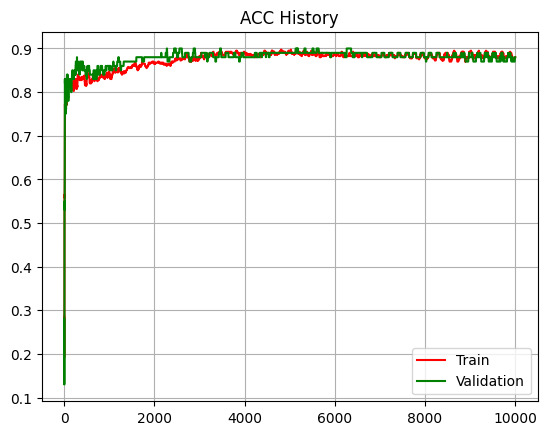

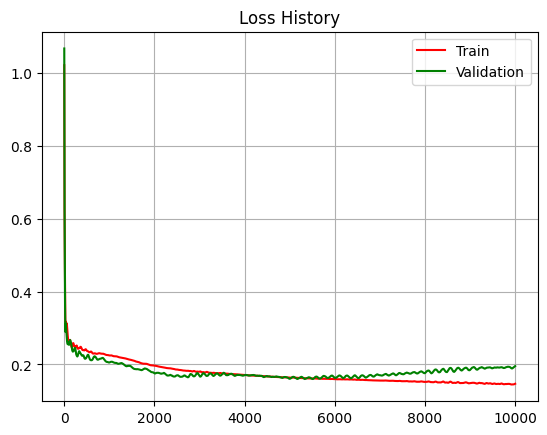

In [134]:
nn.plot_history()

In [135]:
nn.best_acc

0.8975

In [136]:
nn.best_loss

0.1449759832002155

In [137]:
nn.best_acc_val

0.89

In [138]:
nn.best_loss_val

0.16106501739840107

In [139]:
# Plot the decision boundaries
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

Z, _ = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

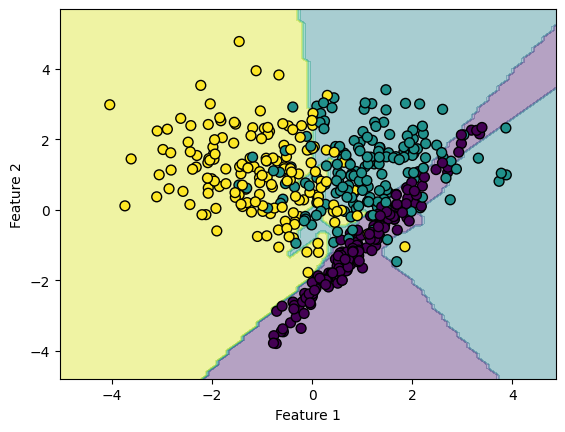

In [140]:
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(dataset[:, 0], dataset[:, 1], c=label, marker='o', s=50, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [53]:
import tensorflow as tf
from sklearn import metrics

In [54]:
# Load data
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [55]:
# Print training set shape - note there are 60,000 training data of image size of 28x28, 60,000 train labels)
print("x_train shape:", train_images.shape, "y_train shape:", train_labels.shape)

# Print the number of training and test datasets
print(train_images.shape[0], 'train set')
print(test_images.shape[0], 'test set')

x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set
10000 test set


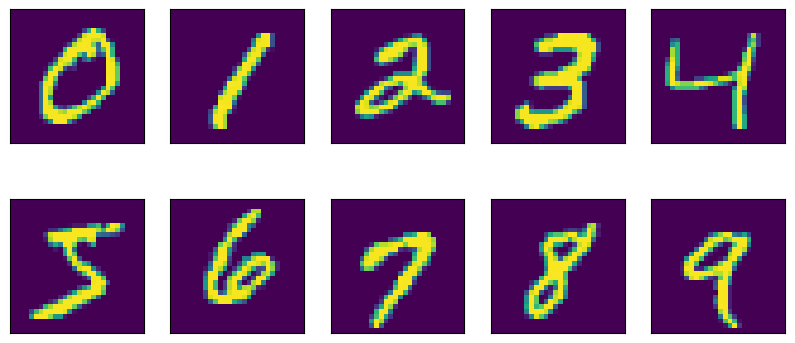

In [56]:
# Display random samples
figure = plt.figure(figsize=(10, 7))
for label_index in range(10):
    ax = figure.add_subplot(3, 5, label_index + 1, xticks=[], yticks=[])
    ax.imshow(train_images[train_labels == label_index][0])

In [57]:
# onehot label
train_y = tf.one_hot(train_labels, depth=10)
test_y = tf.one_hot(test_labels, depth=10)

train_y = np.asarray(train_y)
test_y = np.asarray(test_y)

In [58]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [59]:
train_images.shape

(60000, 784)

In [60]:
nn = neural_network((train_images.shape[1], 1000, 500, 250, 150, 50, train_y.shape[1]))
print(nn.network_structure)

(784, 1000, 500, 250, 150, 50, 10)


In [61]:
nn.fit(train_images, train_y, (test_images, test_y),
       iteration = 18750, print_info = 100,
       use_mini_batch = True , use_adam = False)

Iteration 100:	 Loss = 0.749651,	Accuracy = 0.37,	 Validation Loss = 0.747394,	Validation Accuracy = 0.37
Iteration 200:	 Loss = 0.647642,	Accuracy = 0.49,	 Validation Loss = 0.640222,	Validation Accuracy = 0.49
Iteration 300:	 Loss = 0.604570,	Accuracy = 0.54,	 Validation Loss = 0.600861,	Validation Accuracy = 0.54
Iteration 400:	 Loss = 0.481708,	Accuracy = 0.65,	 Validation Loss = 0.476592,	Validation Accuracy = 0.65
Iteration 500:	 Loss = 0.451425,	Accuracy = 0.67,	 Validation Loss = 0.452776,	Validation Accuracy = 0.67
Iteration 600:	 Loss = 0.444631,	Accuracy = 0.67,	 Validation Loss = 0.446184,	Validation Accuracy = 0.67
Iteration 700:	 Loss = 0.423190,	Accuracy = 0.69,	 Validation Loss = 0.421559,	Validation Accuracy = 0.69
Iteration 800:	 Loss = 0.351917,	Accuracy = 0.75,	 Validation Loss = 0.354292,	Validation Accuracy = 0.75
Iteration 900:	 Loss = 0.343801,	Accuracy = 0.76,	 Validation Loss = 0.344977,	Validation Accuracy = 0.76
Iteration 1000:	 Loss = 0.337826,	Accuracy = 0

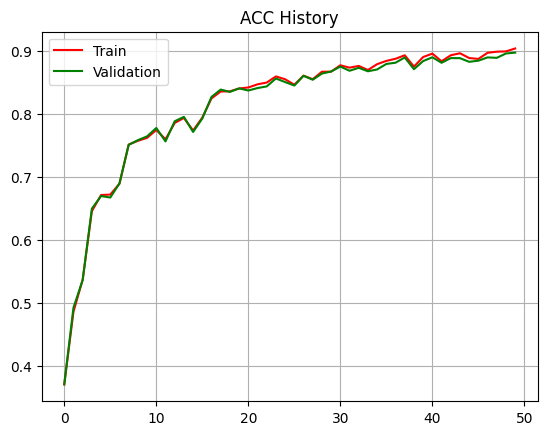

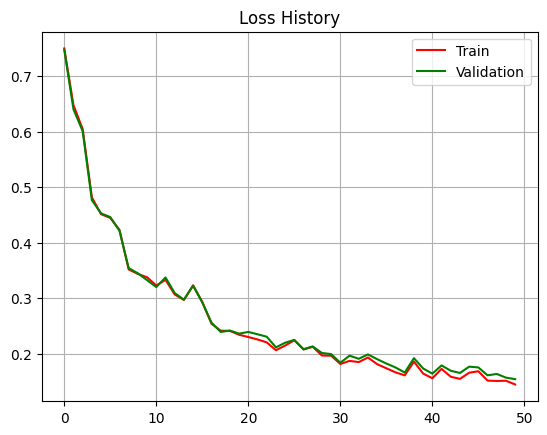

In [62]:
nn.plot_history()

In [63]:
predict, _ = nn.predict(test_images)

In [65]:
print(metrics.classification_report(test_labels, predict))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.96      0.97      0.97      1135
           2       0.89      0.90      0.89      1032
           3       0.87      0.88      0.87      1010
           4       0.91      0.89      0.90       982
           5       0.92      0.78      0.84       892
           6       0.88      0.94      0.91       958
           7       0.88      0.94      0.91      1028
           8       0.85      0.87      0.86       974
           9       0.90      0.84      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



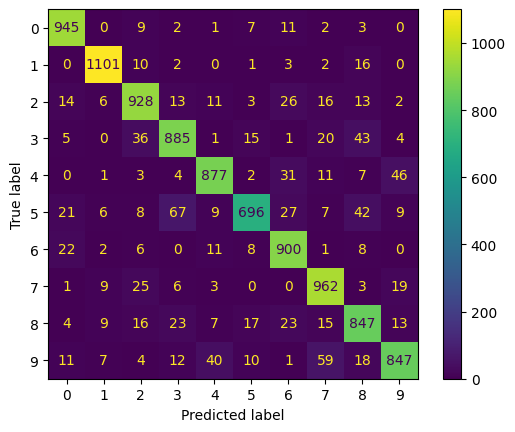

In [67]:
matrix = metrics.confusion_matrix(test_labels, predict)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=np.unique(test_labels))
disp.plot()
plt.show()